# Generic Object Detection
We will be mainly utilising the watershed algorithm to do object detection on plain background.

Code based on https://www.udemy.com/course/python-for-computer-vision-with-opencv-and-deep-learning/

# Failed attempt
- YOLOv7 CLIP: Doesn't work because it does not detect the screw based on pre-trained data
- CounTR: It does not work on screw. and even for the data it is trained on, the result wasn't good. (eg. 2.jpg from FSC147 dataset)

In [1]:
# list of interactive variables
# crop: bilateralfilter filter
# crop: kernel 
# crop cut: to compensate for skewed image

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
%matplotlib inline

In [2]:
def img_read_resize(source, max_width = "default", color = 'rgb'):
    # display in rgb
    if color == 'rgb':
        color = cv2.IMREAD_COLOR
        img = cv2.imread(source, color)
        org_height, org_width, _ = img.shape
    # display in grayscale
    else:
        color = cv2.IMREAD_GRAYSCALE
        img = cv2.imread(source, color)
        org_height, org_width = img.shape
    
    if max_width == "default":
        return img
    else:
        # scale picture according to max width specified
        scale_ratio = org_width/max_width
        scaled_height = int(org_height/scale_ratio)
        img = cv2.resize(img, (max_width, scaled_height), interpolation = cv2.INTER_AREA)
        return img

In [3]:
def img_display(img, cmap=None):
    # fig = plt.figure()
    # ax = fig.add_subplot()
    # ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(img,cmap=cmap)

In [11]:
def crop_background(img, filter_intensity = 33, kernel_size = (3,3), crop_percent = 2.5):
    
    # We want to crop out the background and only leave the white paper as the border of the image
    # we blur the image first so that the unnecessary details doesn't show up
    # we use bilateralFilter instead of other methods (such as medianblur, gaussianblur) as it gives us the sharpest of the white paper edges
    # while also removing those unnecesary details from the background
    blurred_img = cv2.bilateralFilter(img,filter_intensity,75,75)
    # we follow up with a open morphing to remove any unwanted small white dots on a black background. 
    # so that our image before finding contours is cleaner
    kernel = np.ones(kernel_size, np.uint8)
    blurred_img = cv2.morphologyEx(blurred_img, cv2.MORPH_OPEN, kernel)
    
    # change image to grayscale so that we can split it up by intensity of graycolor
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)

    # set threshold to filter out those colors that are not white (we define white as below 140 value)
    # then for those that is above the threshold, we change it to black (255)
    # the part that you want to detect should be white. 
    ret, thres_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # DESKEW image based on url below
    # https://stackoverflow.com/questions/59660933/how-to-de-skew-a-text-image-and-retrieve-the-new-bounding-box-of-that-image-pyth/59672620#59672620
    def determine_score(arr, angle):
        data = rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    scores = []
    angles = np.arange(-5, 5 + 1, 1)
    for angle in angles:
        histogram, score = determine_score(thres_img, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = thres_img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected_img = cv2.warpAffine(thres_img, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    # contours: https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    # cv2.RETR_EXTERNAL will return all the external contours
    # cv2.CHAIN_APPROX_SIMPLE will only return 4 points instead of detailed pixel by pixel points 
    contours, hierarchy  = cv2.findContours(corrected_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort the contours to get the biggest contour (just in case we get more than 1 contour)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # to crop the image based on the contour
    # we pass in contours[0] because there's only 1 contour is our case
    x, y, w, h = cv2.boundingRect(contours[0])


    # we crop off abit more to compensate for the skewness of the picture
    org_height, org_width = thres_img.shape
    cut_pixels = int(org_width*crop_percent/100)
    cropped_img = img[y+cut_pixels:y+h-cut_pixels, x+cut_pixels:x+w-cut_pixels]
   
    return cropped_img

In [12]:
def object_count(img, kernel_size = (3,3), smoothing = 0):
    # blur the image using gaussianblur
    # we don't use bilateral because we only want the  outline of the object, bilateral highlights too much edges
    blurred_img = cv2.GaussianBlur(cropped_img,(33,33),0)

    # change image to grayscale so that we can split it up by intensity of graycolor
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)

    # instead of using normal threshold where we set the threshold manually, we use adaptive threshold because the light intensity varies across the picture
    # https://pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/
    # 21 is the grid in which we search for optimum threshold (21 by 21)
    # 10 is our finetune threshold related to the ADAPTIVE_THRESH_MEAN_C
    # we don't use adaptive threshold because we want the threshold to be singular instead of adaptive across the image. so that the output would be clean
    # thres_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
    thres_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)

    # declare kernet for smooth and dilating
    kernel = np.ones((3,3), np.uint8)

    # perform more smoothing to prevent unnecessary details from being detected
    if smoothing:
        # dilate grow the edges of brighter white pixels
        smoothed_img = cv2.dilate(thres_img, kernel, iterations=1)
        # morph_open is useful to remove any unwanted small white pixels on a black background
        smoothed_img = cv2.morphologyEx(smoothed_img, cv2.MORPH_OPEN, kernel)

        target_img = smoothed_img
        print("Smoothing performed")
    else:
        target_img = thres_img
    
    # Get the pixels which we are sure that is the background
    sure_bg = cv2.dilate(target_img, kernel, iterations=3)

    # Perform distance transformation. pixels that are further away from the background would be given higher white intensity
    # thereby increasing our confidence that those intense white are the foreground (our object of interest)
    # https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
    distance_transformed_out = cv2.distanceTransform(target_img, cv2.DIST_L2, 5)

    # do another threshold function to gather the pixels which we are sure is the foregroud after distanceTransform
    ret, sure_fg = cv2.threshold(distance_transformed_out.astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # get the unknown area
    unknown = cv2.subtract(sure_bg, sure_fg)

    # connectedComponents help us to treat each markers as individual components
    # https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/
    ret, markers = cv2.connectedComponents(sure_fg)

    # we add 1 to markers to differentiate the eventual background from the unknown pixel which we equates to 0 in the next line
    markers = markers+1
    markers[unknown==255] = 0

    # perform watershed
    # https://pyimagesearch.com/2015/11/02/watershed-opencv/
    # we have to perform watershed on a color image
    markers = cv2.watershed(blurred_img, markers)

    # return number of unique objects
    counter = 0
    for marker in np.unique(markers):
        # -1 refers to the outline
        # 1 refers to the background
        # all other numbers means different classes
        if marker == -1 or marker == 1:
            continue
        counter += 1

    return markers, counter

5


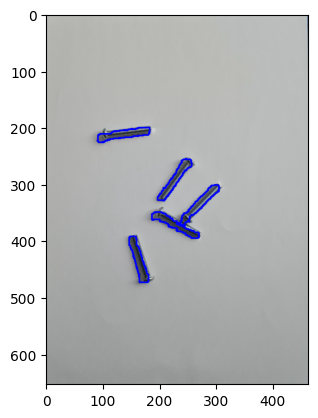

In [18]:
org_img = img_read_resize("../Images/20221206_103743.jpg", max_width= 640)
cropped_img = crop_background(org_img)
markers, counter = object_count(cropped_img)
final_img, counter = display_contours(cropped_img, markers)
img_display(final_img)

print(counter)

In [15]:
def display_contours(cropped_image, markers):
    # loop over the unique labels returned by the Watershed algorithm
    counter = 0
    for marker in np.unique(markers):
        # if the marker is one, we are examining the 'background'
        # if the marker is -1, we are looking at the outline
        # so simply ignore it
        if marker == 1 or marker == -1:
            continue
        # otherwise, allocate create a mask just for the particular marker region
        mask = np.zeros(markers.shape, dtype="uint8")
        # for every marker (ie, -1, 2, 3, 4, 5, 6), change it to 255 each time.
        # now we will only have mask that has 1 marker each time
        mask[markers == marker] = 255
        # detect contours in the mask and grab the largest one
        contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        final_image = cv2.drawContours(cropped_image, contours, 0, (0,0,255), 2)
        counter += 1
    return final_image, counter

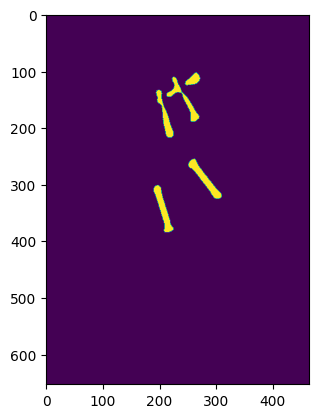

In [165]:
# color_out_blurred = cv2.medianBlur(cropped_img,11)
color_out_blurred = cv2.GaussianBlur(cropped_img,(33,33),0)
# color_out_blurred = cv2.bilateralFilter(cropped_img,33,75,75)
gray_out = cv2.cvtColor(color_out_blurred, cv2.COLOR_RGB2GRAY)
# instead of using normal threshold where we set the threshold manually, we use adaptive threshold
# https://pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/
# 21 is the grid in which we search for optimum threshold (21 by 21)
# 10 is our finetune threshold related to the ADAPTIVE_THRESH_MEAN_C
# we don't use adaptive threshold because we want the threshold to be singular instead of adaptive across the image. so that the output would be clean
# thres_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
thres_out = cv2.adaptiveThreshold(gray_out, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
img_display(thres_out)

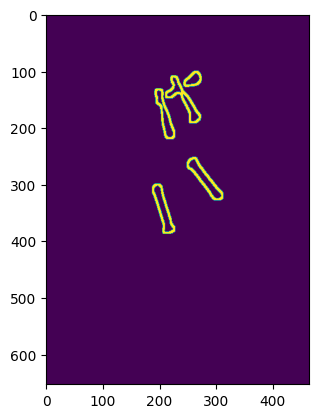

In [166]:
# we want to try and smooth out the edges as much as possible to prevent false detection. we do this using morphologyEX
# define kernel to use to smoothen
kernel = np.ones((3,3), np.uint8)
# morphed_out = cv2.dilate(thres_out, kernel, iterations=1)
# morphed_out = cv2.morphologyEx(morphed_out, cv2.MORPH_OPEN, kernel)
# get the confirmed background of the image after dilation which filter out those pixel that is even remotely white/gray
sure_bg = cv2.dilate(thres_out, kernel, iterations=3)
# perform distance transformation. Basically, further away from blacks, it will have higher value. 
# meaning that it is more confirmed that it is a foreground (ie. our object of interest)
distance_transformed_out = cv2.distanceTransform(thres_out, cv2.DIST_L2, 5)
# do another threshold such that only those extreme whites from distanceTransform are considered sure foreground
# ret, sure_fg = cv2.threshold(distance_transformed_out, 0.1*distance_transformed_out.max(), 255, 0)
ret, sure_fg = cv2.threshold(distance_transformed_out.astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# print(type(sure_fg))
# sure_fg = np.uint8(sure_fg)
# print(type(sure_fg))
# get the unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
img_display(unknown)

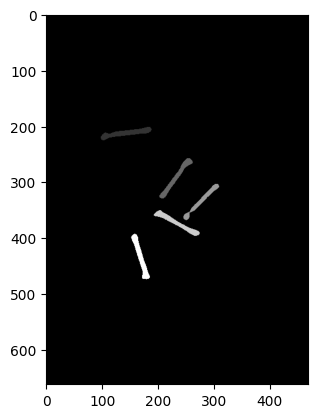

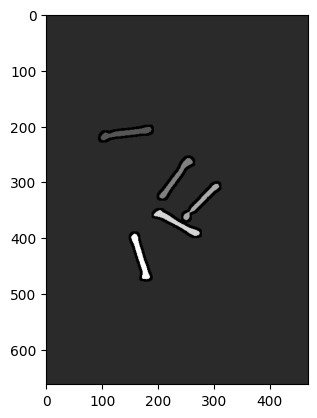

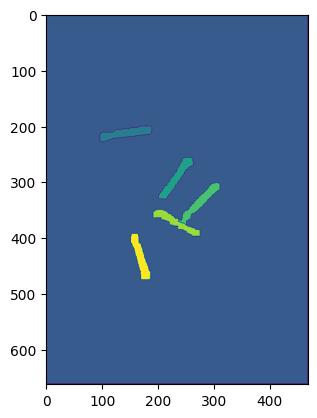

In [32]:
# connectedComponents help us to treat each markers as individual components
# https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/
ret, markers = cv2.connectedComponents(sure_fg.astype(np.uint8))

markers = markers+1
markers[unknown==255] = 0

# markers = np.uint8(markers)
markers = cv2.watershed(color_out_blurred, markers)


In [46]:
print("[INFO] {} unique segments found".format(len(np.unique(markers)) - 1))

[INFO] 6 unique segments found


In [172]:
# with np.printoptions(threshold=np.inf):
#     print(markers)

5


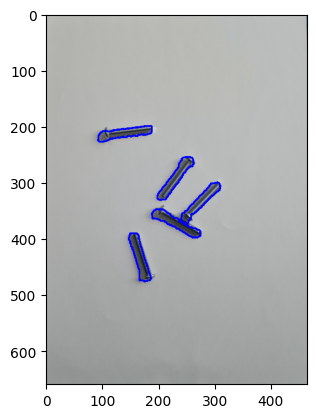

In [183]:
import imutils
final = color_out.copy()
# loop over the unique labels returned by the Watershed algorithm
counter = 0
for marker in np.unique(markers):
    # if the marker is one, we are examining the 'background'
    # if the marker is -1, we are looking at the outline
    # so simply ignore it
    if marker == 1 or marker == -1:
        continue
    # otherwise, allocate create a mask just for the particular marker region
    mask = np.zeros(markers.shape, dtype="uint8")
    # for every marker (ie, -1, 2, 3, 4, 5, 6), change it to 255 each time.
    # now we will only have mask that has 1 marker each time
    mask[markers == marker] = 255
    # detect contours in the mask and grab the largest one
    contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # cnts = imutils.grab_contours(cnts)
    # c = max(cnts, key=cv2.contourArea)


    ##########################
    # FIND A WAY TO CALCULATE THE AREA, and if it's too small or too big, remove it!!!!
    ##########################
    # draw a circle enclosing the object
    # ((x, y), r) = cv2.minEnclosingCircle(c)
    # cv2.circle(final, (int(x), int(y)), int(r), (0, 255, 0), 2)
    # cv2.putText(final, "#{}".format(marker), (int(x) - 10, int(y)),
    #     cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    final = cv2.drawContours(final, contours, 0, (0,0,255), 2)
    counter += 1

img_display(final)
print(counter)